# State Frequency, Compare Bert Zero and Bert Last

In [1]:
import torch 

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pandas import DataFrame

from tqdm import tqdm 

from matplotlib.pyplot import figure
import matplotlib as mpl

In [93]:
def read_state_freq(path):
    state_freq = np.zeros(2000)
    state_nonstop_freq = np.zeros(2000)
    with open(path) as fd:
        lines = fd.readlines()
        for li, l in enumerate(lines):
            if(li % 3 == 0):
                l = l.split()
                state_id = int(l[1])
                state_freq[state_id] = int(l[3])
                state_nonstop_freq[state_id] = int(l[7])
    return state_freq, state_nonstop_freq

In [18]:
def read_aligned(filepath):
    aligned_states = []
    lines = open(filepath).readlines()
    for l in lines:
        l = l.split()
        l_ = {}
        l_['state_id'] = int(l[1])
        if(int(l[3]) == 0): l_['type'] = 'static'
        if(int(l[3]) == 1): l_['type'] = 'dynamic'
        if(int(l[3]) == 2): l_['type'] = 'both'
        l_['occ'] = int(l[5])
        aligned_states.append(l_)
    return aligned_states

In [19]:
def read_not_aligned(filepath):
    not_aligned_states = []
    lines = open(filepath).readlines()
    for li, l in enumerate(lines):
        if(li % 3 == 0):
            l = l.split()
            l_ = {}
            l_['state_id'] = int(l[1])
            l_['occ'] = int(l[3])
            l_['type'] = l[-1].split('=')[-1]
            assert(l_['type'] in ['LEX', 'SYN', 'SEM', 'NA'])
            not_aligned_states.append(l_)
    return not_aligned_states

In [94]:
state_freq_last, state_nonstop_freq_last = read_state_freq('bertnet_0.0.6.4_dev_epoch_-1_s2w_sw.txt')

In [95]:
state_freq_zero, state_nonstop_freq_zero = read_state_freq('bertnet_0.1.9.1_dev_epoch_-1_s2w_sw.txt')

In [96]:
state_freq_zero[1191]

819.0

In [97]:
state_nonstop_freq_zero[1191]

240.0

In [20]:
aligned_last_file = 'bertnet_0.0.6.4_dev_epoch_-1_aligned.txt'
not_aligned_last_file = '../annotation/yaofu/output1.txt'

aligned_zero_file = 'bertnet_0.1.9.1_dev_epoch_-1_aligned.txt'
not_aligned_zero_file = '../annotation/yaofu/output2.txt'

In [21]:
aligned_last = read_aligned(aligned_last_file)
aligned_zero = read_aligned(aligned_zero_file)
not_aligned_last = read_not_aligned(not_aligned_last_file)
not_aligned_zero = read_not_aligned(not_aligned_zero_file)

In [98]:
state_freq_last[1850]

1190.0

In [99]:
state_nonstop_freq_last[1850]

1167.0

In [14]:
def plot_state_dist(state_freq, state_nonstop_freq):
    idx_sort = state_freq.argsort()[::-1]
    state_stop_freq = state_freq - state_nonstop_freq
    
    figure(figsize=(6, 4), dpi=200)
    # fig, ax = plt.subplots()
    state_freq_ = state_freq[idx_sort] + 1
    state_stop_freq_ = state_stop_freq[idx_sort] + 1
    state_nonstop_freq_ = state_nonstop_freq[idx_sort] + 1

    state_stop_freq_vis = np.log(state_freq_) * (state_stop_freq_ / state_freq_)
    state_nonstop_freq_vis = np.log(state_freq_) * (state_nonstop_freq_ / state_freq_)

    fig_stop = plt.bar(x=np.arange(2000), height=state_stop_freq_vis, color='lightskyblue')
    fig_nonstop = plt.bar(x=np.arange(2000), height=state_nonstop_freq_vis, bottom=state_stop_freq_vis, color='tab:blue')

    plt.legend((fig_stop, fig_nonstop), 
               ('Stopwords', 'Non-stopwords'), 
               fontsize=15)
    # plt.yscale('log')
    plt.tick_params(axis='both', which='both', left=False, labelsize=15, labelleft=False) 
    return

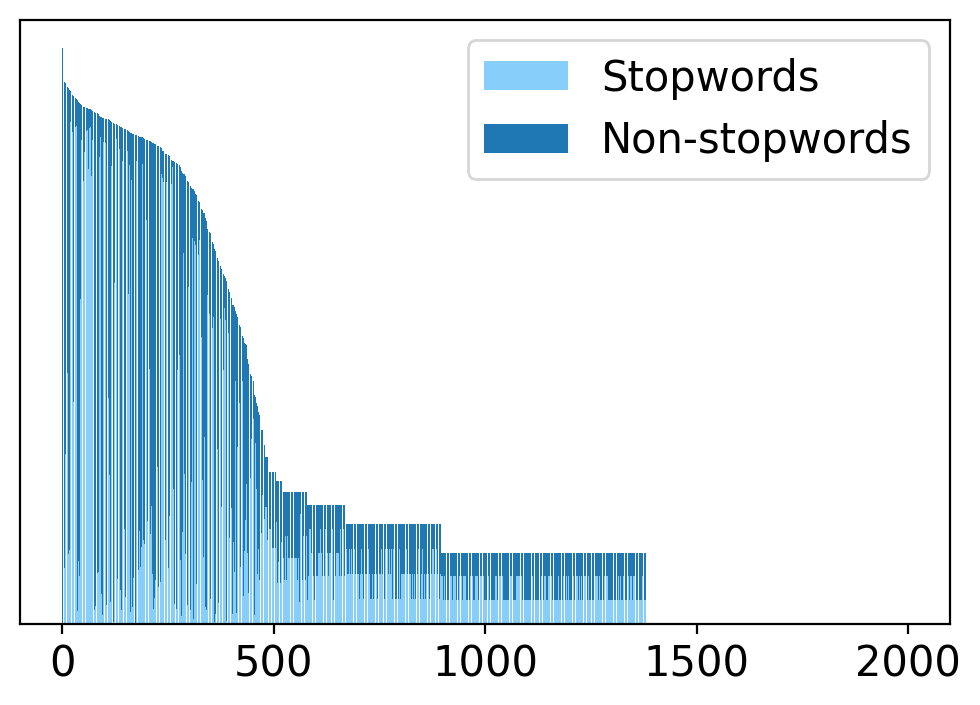

In [15]:
plot_state_dist(state_freq_last, state_nonstop_freq_last)

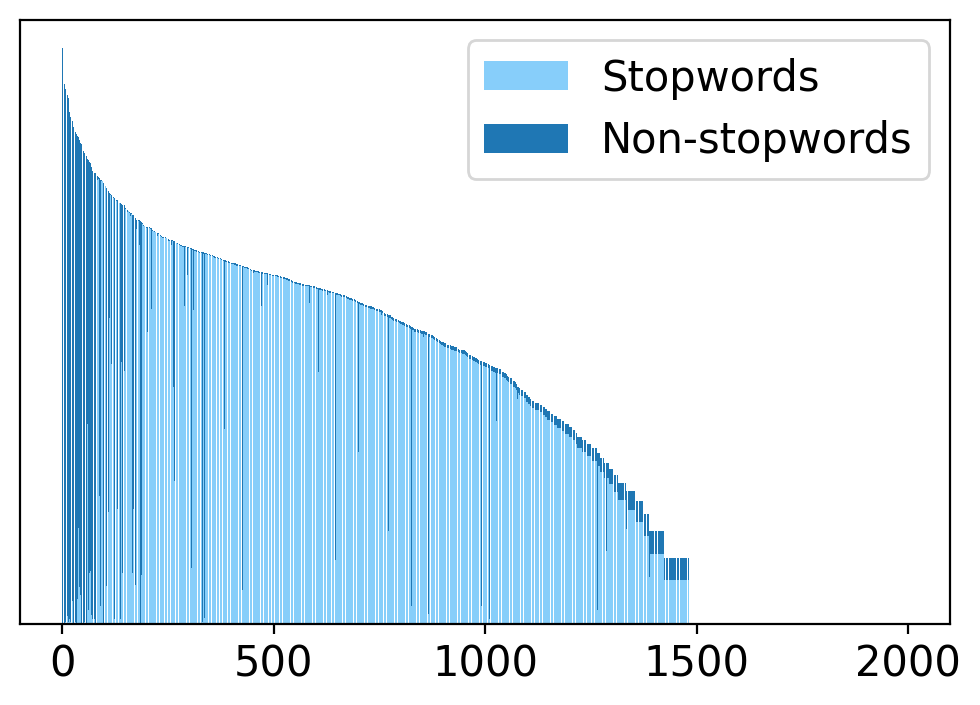

In [17]:
plot_state_dist(state_freq_zero, state_nonstop_freq_zero)

In [104]:
def plot_state_dist_by_alignment(state_freq, state_nonstop_freq, aligned, not_aligned, end_id=-1):
    idx_sort = state_freq.argsort()[::-1]
    state_stop_freq = state_freq - state_nonstop_freq
    
    ###
    combined = {}
    for l in aligned: combined[l['state_id']] = l['type']
    for l in not_aligned: combined[l['state_id']] = l['type']

    aligned_x, state_stop_freq_aligned, state_nonstop_freq_aligned = [], [], []
    not_aligned_x, state_stop_freq_not_aligned, state_nonstop_freq_not_aligned = [], [], []
    
    for li, lid in enumerate(idx_sort):
        if(lid in combined):
            if(combined[lid] in ['static', 'dynamic', 'both']): 
                aligned_x.append(li)
                state_stop_freq_aligned.append(np.log(state_freq[lid] + 1) * (state_stop_freq[lid] / state_freq[lid]))
                state_nonstop_freq_aligned.append(np.log(state_freq[lid] + 1) * (state_nonstop_freq[lid] / state_freq[lid]))
            else:
                not_aligned_x.append(li)
                state_stop_freq_not_aligned.append(-np.log(state_freq[lid] + 1) * (state_stop_freq[lid] / state_freq[lid]))
                state_nonstop_freq_not_aligned.append(-np.log(state_freq[lid] + 1) * (state_nonstop_freq[lid] / state_freq[lid]))
    # aligned_x, state_stop_freq_aligned, state_nonstop_freq_aligned = reindex(aligned_x, state_stop_freq_aligned, state_nonstop_freq_aligned)
    # not_aligned_x, state_stop_freq_not_aligned, state_nonstop_freq_not_aligned = reindex(not_aligned_x, state_stop_freq_not_aligned, state_nonstop_freq_not_aligned)
    
    ###
    fig = plt.figure(figsize=(6, 2.5), dpi=200)
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    
    axs[0].bar(x=aligned_x[:end_id], height=state_stop_freq_aligned[:end_id], color='tab:orange')
    axs[0].bar(x=aligned_x[:end_id], height=state_nonstop_freq_aligned[:end_id], bottom=state_stop_freq_aligned[:end_id], color='tab:blue')
    # axs[0].legend(loc='upper right')

    axs[1].bar(x=not_aligned_x, height=state_stop_freq_not_aligned, color='tab:orange', label='Stop words')
    axs[1].bar(x=not_aligned_x, height=state_nonstop_freq_not_aligned, bottom=state_stop_freq_not_aligned, color='tab:blue', label='Content words')
    axs[1].legend(loc='lower right')
    
    
    axs[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    left=True,
    labelleft=False) # labels along the bottom edge are off
    axs[0].set_ylabel('Aligned')
    
    axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,
    labelbottom=False) # labels along the bottom edge are off
    
    axs[1].tick_params(
    axis='y',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    left=True,
    labelleft=False) # labels along the bottom edge are off
    axs[1].set_ylabel('Not Aligned')
    
    axs[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,
    labelbottom=True) # labels along the bottom edge are off
    return

/home/s1946695/miniconda3/envs/_lm_adaptation_dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/s1946695/miniconda3/envs/_lm_adaptation_dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


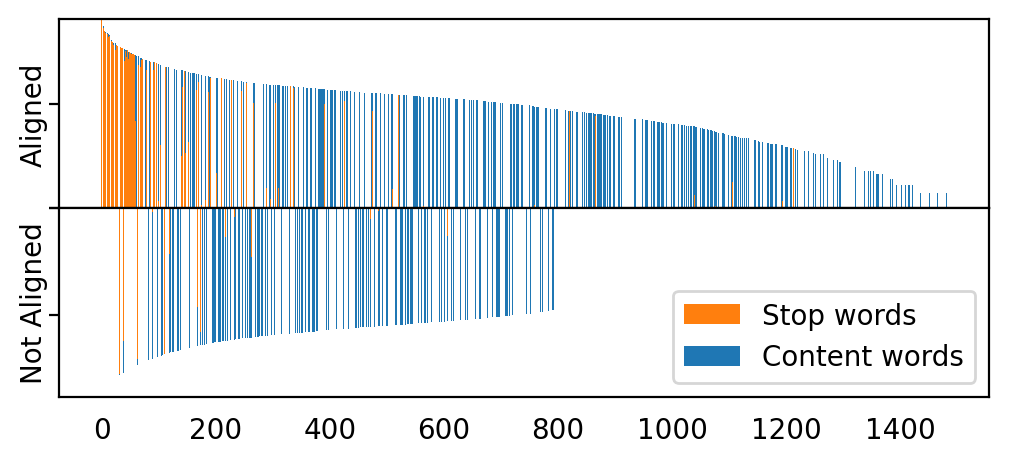

In [105]:
plot_state_dist_by_alignment(state_freq_zero, state_nonstop_freq_zero, aligned_zero, not_aligned_zero)

/home/s1946695/miniconda3/envs/_lm_adaptation_dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/s1946695/miniconda3/envs/_lm_adaptation_dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


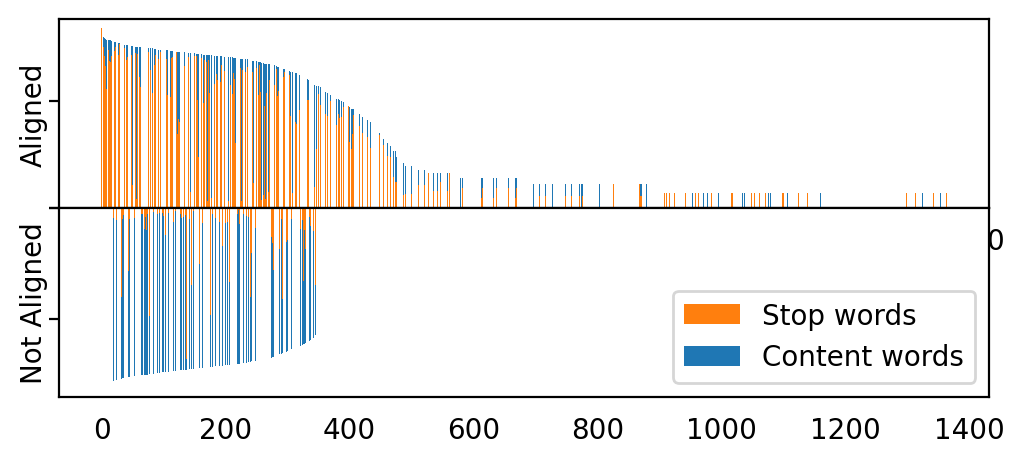

In [102]:
plot_state_dist_by_alignment(state_freq_last, state_nonstop_freq_last, aligned_last[:-500], not_aligned_last)

/home/s1946695/miniconda3/envs/_lm_adaptation_dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/s1946695/miniconda3/envs/_lm_adaptation_dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


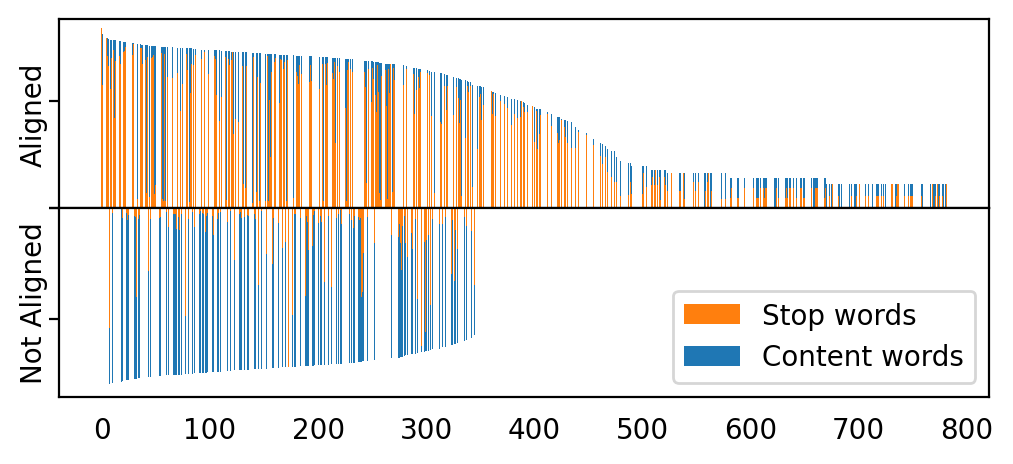

In [106]:
plot_state_dist_by_alignment(state_freq_last, state_nonstop_freq_last, aligned_last, not_aligned_last, -550)